# Global alignment
This notebook covers the experiment done using a global alignment metric over the 5 chosen seeds (1, 29, 42, 51,1000) 

## Library import

In [1]:
# Importing of the all modules
from functions.CIF_Functions import make_df_new
from functions.cleaning_functions import select_ca
from functions.Sliding_Functions import local_rmsd_plotter

import glob
import numpy as np
from numpy import array,dot
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from MDAnalysis.analysis import align  
from MDAnalysis.analysis.rms import rmsd

## Cif import

In [13]:
#               Predictions
###############################################
# select input files
filepaths= glob.glob('cif_files/Predictions/SEEDMATCHED/*_ptms/*.cif')
filepaths.extend(glob.glob('cif_files/Predictions/SEEDMATCHED/*_noptms/*.cif'))

# put all predictions in a list as analysable dataframes
grouped_model_list = {}

for filepath in filepaths:
    dataframes = make_df_new(filepath)[0][0]
    dataframes_CA = select_ca(dataframes)
    dataframes_CA.index = range(len(dataframes_CA))
    
    # splitting filepaths to make readable names
    grouped_model_list[filepath.split("\\")[-1][11:-4]] = dataframes_CA

#               Crystal
###############################################
XR_PATH = "cif_files\\Crystals\\7stz (1).cif"
xr_df, _ = make_df_new(XR_PATH)
xr_df_CA = select_ca(xr_df[0])

## Analysis
1. RMSD vs Crystal
2. Sum RMSDlist vs Crystal from sliding window
3. Comparing Predictions vs Crystal, by each barrel (LOCAL ALIGMENT)
4. Comparing Prediction vs Crystal CALCIUM

In [14]:
# Comparing Prediction vs Crystal (GLOBAL ALIGNMENT)
rmsdlist = []
for i in list(grouped_model_list.keys()):
    df_a = xr_df_CA
    df_b = grouped_model_list[i]
    x= array(df_a[df_a.columns[10:13]][10:-10]).astype(float)
    x_mean_centered = x - (sum(x)/len(x))
    y= array(df_b[df_b.columns[10:13]][10:-10]).astype(float)
    y_mean_centered = y - (sum(y)/len(y))

    _, rms = align.rotation_matrix(x_mean_centered, y_mean_centered)
    
    rmsdlist.append(rms)

# Comparing Prediction vs Crystal sliding window (LOCAL ALIGNMENT)
rmsdlist2 = []
for i in list(grouped_model_list.keys()):
    df_a = xr_df_CA
    df_b = grouped_model_list[i]
    
    _,localrms_list,_ = local_rmsd_plotter(df_a,df_b,stepsize=2,win_size=100)
    rmsdlist2.append(sum(localrms_list))

# Comparing Predictions vs Crystal, by each barrel (LOCAL ALIGMENT)
rmsdlist3 = []
for i in list(grouped_model_list.keys()):
    nbarrel = 1
    df_a = xr_df_CA
    df_b = grouped_model_list[i]
    rmslist = []
    for barrel in [(10,102),(102,215),(215,327),(327,436),(436,520)]:
        x= array(df_a[df_a.columns[10:13]][barrel[0]:barrel[1]]).astype(float)
        x_mean_centered = x - (sum(x)/len(x))
        y= array(df_b[df_b.columns[10:13]][barrel[0]:barrel[1]]).astype(float)
        y_mean_centered = y - (sum(y)/len(y))
        _, rms = align.rotation_matrix(x_mean_centered, y_mean_centered)
        rmslist.append(rms)
    rmsdlist3.append(sum(rmslist)/len(rmslist))

# Comparing Prediction vs Crystal CALCIUM
from functions.cleaning_functions import get_hetatm_rmsd
rmsdlist4 = []
for i in filepaths:
    rms = get_hetatm_rmsd(XR_PATH,i)
    rmsdlist4.append(rms)

## Viewing results


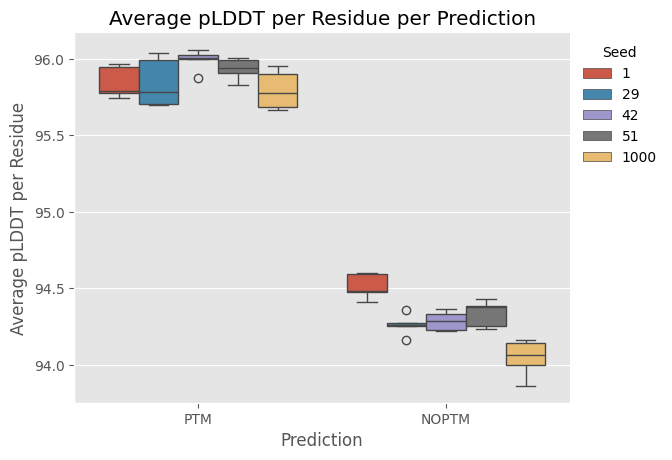

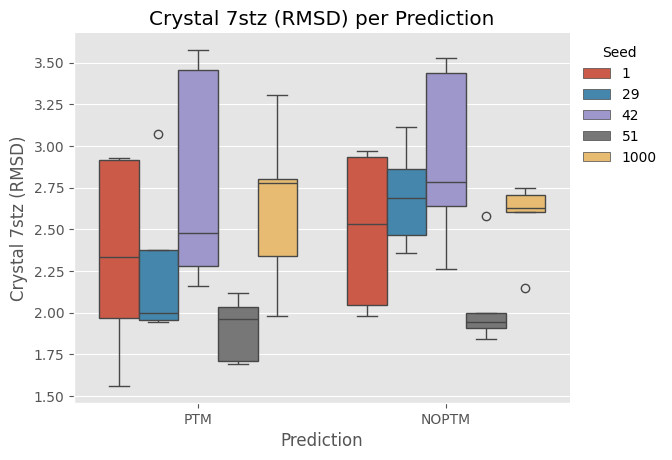

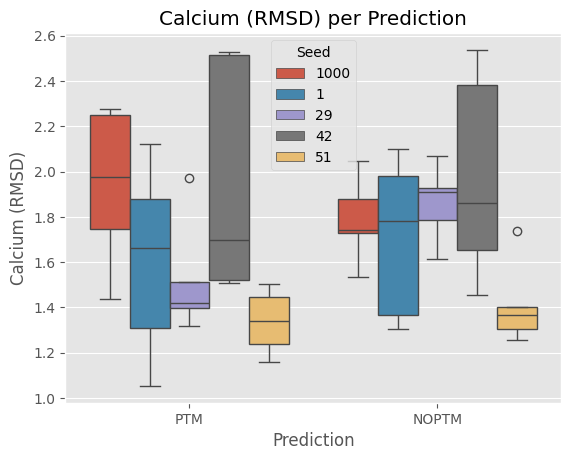

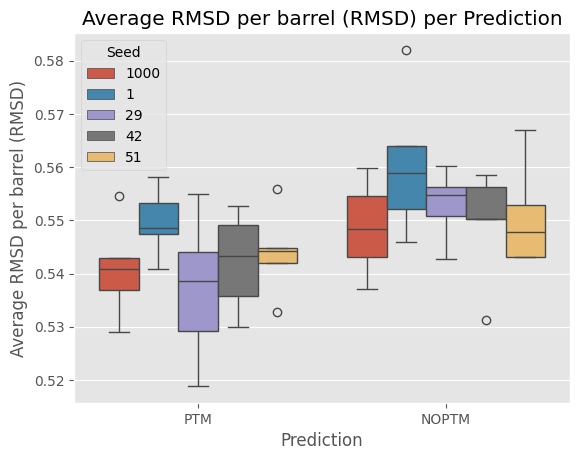

In [15]:
ptmlist = ["PTM" for i in (range(int(len(grouped_model_list)/2)))]
ptmlist.extend(["NOPTM" for i in range(int(len(grouped_model_list)/2))])
seedlist = [filepath.split("_")[3][4:] for filepath in filepaths]
#plddtavg = [sum(grouped_model_list[i]["B_iso_or_equiv"].astype(float))/len(grouped_model_list[i]["B_iso_or_equiv"].astype(float)) for i in list(grouped_model_list.keys())]
plddtavg = [np.mean(grouped_model_list[i]["B_iso_or_equiv"].astype(float)) for i in list(grouped_model_list.keys())]

df= pd.DataFrame({"Keys":list(grouped_model_list.keys()),
                  "Prediction":ptmlist,
                  "Seed":seedlist,
                  "Crystal 7stz (RMSD)":rmsdlist,
                  "SlidingWindow RMSD (SUM)":rmsdlist2,
                  "Average RMSD per barrel (RMSD)":rmsdlist3,
                  "Average pLDDT per Residue":plddtavg,
                  "Calcium (RMSD)":rmsdlist4})

plt.style.use('ggplot')

x= "Prediction"
y = "Average pLDDT per Residue"
sns.boxplot(data=df,x=x,y=y,hue_order=["1","29","42","51","1000"],hue="Seed")
plt.title(f"{y} per {x}")
plt.legend(title="Seed",frameon=False,bbox_to_anchor=(1.2,1))
sns.despine(offset=0)
plt.show()

x= "Prediction"
y = "Crystal 7stz (RMSD)"
sns.boxplot(data=df,x=x,y=y,hue_order=["1","29","42","51","1000"],hue="Seed")
plt.title(f"{y} per {x}")
plt.legend(title="Seed",frameon=False,bbox_to_anchor=(1.2,1))
sns.despine(offset=0)
plt.show()

x= "Prediction"
y = "Calcium (RMSD)"
sns.boxplot(data=df,x=x,y=y,hue="Seed")
plt.title(f"{y} per {x}")
plt.show()


x= "Prediction"
y = "Average RMSD per barrel (RMSD)"
sns.boxplot(data=df,x=x,y=y,hue="Seed")
plt.title(f"{y} per {x}")
plt.show()

## Picking most confident models

In [28]:
df = df.sort_values(by=["Average pLDDT per Residue"])
print(list(df[df["Prediction"]=="NOPTM"]["Keys"])[-1])
print(list(df[df["Prediction"]=="PTM"]["Keys"])[-1])

seed1_noptms_model_1
seed42_ptms_model_3
